# Bayesian Optimization: Lasers Application

_Prepared by Ritz Aguilar for Thrill Summer School at Toulon, France, October 2024_

#### Objectives
- Differentiate the effects of using different utility/acquistion functions for BO.
- Use varying kernels for the Gaussian Process, e.g. Constant, Matern, RBF, etc.

## Exercise: Bayesian Optimization for Laser Stability

Problem Definition:

We want to minimize fluctuations (noise) in the laser output power by adjusting system parameters like pump strength, cavity alignment, or temperature. The goal is to reduce the variability in the output power (standard deviation) while keeping the mean output power close to a target value.

Steps for the Simulation:

- Define Laser Power Function: The laser power can be affected by the parameters you control (pump strength $D_0$, temperature $T$, etc.). The power may vary over time due to inherent noise. We'll simulate this variation as a function of time.

- Fluctuations: We'll model noise as random variations (Gaussian noise) added to the mean output power. The goal is to minimize the standard deviation of these fluctuations.

- Objective: We'll minimize the standard deviation of the output power, which indicates the stability of the laser. The optimization process will find the best parameter settings that reduce this noise.

### Exercise 1

We will first simulate a laser system and optimize its stability by adjusting the *pump strength* $S_0$. The goal is to minimize fluctuations in the laser's output power due to noise and temperature sensitivity.

#### Problem Description
Given some target output power, we aim to find the best pump strength $S_0$ to minimize output power fluctuations. The power fluctuations are affected by:
- Pump strength $S_0$,
- Temperature $T$,
- Gaussian noise, simulating instability in the laser system or random fluctuations in the laser output

We will use Bayesian optimization to find the optimal $S_0$ that stabilizes the laser output.

#### Step 1.1: Simulate the Laser Power Function

We create a function that models the laser output power as a function of pump strength $S_0$, temperature $T$, and some added noise to represent fluctuations in the laser output. This will form the basis of our objective function for optimization.

The laser's output power $P$ can be described as a function of pump strength $P_s$ and temperature $T$. The equation we use is:

$$
P(S_0, T) = P_0 \left( 1 + \alpha S_0 - \beta (T - T_{\text{opt}})^2 \right) + \text{noise},
$$

where
- $P_0$ is the baseline laser power,
- $\alpha$ is the scaling factor for pump strength $S_0$,
- $\beta$ is the temperature sensitivity factor,
- $T_{\text{opt}}$ is the optimal temperature,
- $\text{noise}$: Gaussian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

sns.set_style("ticks")
sns.set_context("notebook")

np.random.seed(42)

In [2]:
# Simulated laser power function with pump strength Ps and temperature T
def laser_power(S0, T, P0=1.0, alpha=0.1, beta=0.02, T_opt=25.0, noise_level=0.1):
    """
    Simulate the laser power output as a function of pump strength (S0) and temperature (T).
    The power fluctuates due to Gaussian noise, which represents the instability.
    
    Args:
        S0 (float): Pump strength.
        T (float): Temperature.
        P0 (float): Baseline power.
        alpha (float): Scaling factor for pump strength.
        beta (float): Temperature sensitivity factor.
        T_opt (float): Optimal temperature.
        noise_level (float): Level of Gaussian noise added to simulate fluctuations.

    Returns:
        float: Simulated laser output power.
    """
    # Mean power as a function of Ps and T
    # mean_power = P0 * (1 + alpha * S0 - beta * (T - T_opt)**2)
    mean_power = P0 * (1 + alpha * S0 - beta * ((T - T_opt)**2))

    # Add Gaussian noise to simulate fluctuations
    noise = np.random.normal(0, noise_level)
    
    return mean_power + noise

Visualize the laser power function.

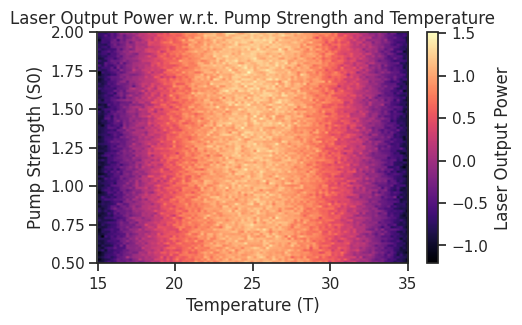

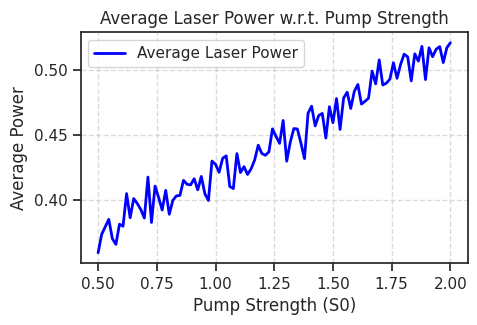

In [3]:
# Set up a grid of S_0 and T values
S0_values = np.linspace(0.5, 2.0, 100)  # Pump strength range
T_values = np.linspace(15, 35, 100)      # Temperature range

# Initialize a 2D array to store the power values
power_values = np.zeros((len(S0_values), len(T_values)))

# Simulate power for each combination of S_0 and T
for i, S0 in enumerate(S0_values):
    for j, T in enumerate(T_values):
        power_values[i, j] = laser_power(S0, T)

# Plot the heatmap of power as a function of S_0 and T
plt.figure(figsize=(5, 3))
plt.imshow(power_values, extent=[T_values.min(), T_values.max(), 
                                 S0_values.min(), S0_values.max()],
           origin='lower', aspect='auto', cmap='magma')
plt.colorbar(label='Laser Output Power')
plt.xlabel('Temperature (T)')
plt.ylabel('Pump Strength (S0)')
plt.title('Laser Output Power w.r.t. Pump Strength and Temperature')
plt.show()

# Now, let's plot the average intensity of laser power as a line plot
average_power = np.mean(power_values, axis=1)  # Average across temperature values

plt.figure(figsize=(5, 3))
plt.plot(S0_values, average_power, 'b-', lw=2, label='Average Laser Power')
plt.xlabel('Pump Strength (S0)')
plt.ylabel('Average Power')
plt.title('Average Laser Power w.r.t. Pump Strength')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.show()

##### Exercise 1.1: Add a line plot for laser power vs pump strength at optimal T.

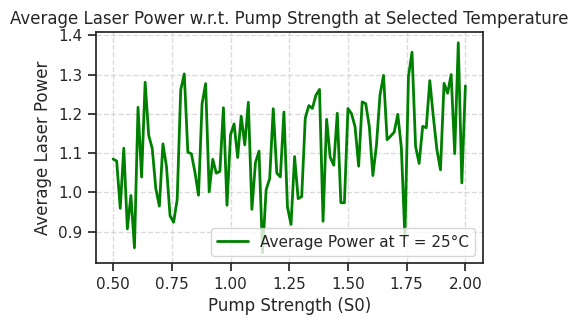

In [4]:
###### Solution 1.1
S0_grid, T_grid = np.meshgrid(S0_values, T_values)

# Calculate the mean laser power for each (S_0, T) combination
mean_power_values = np.zeros_like(S0_grid)

for i in range(S0_grid.shape[0]):
    for j in range(S0_grid.shape[1]):
        mean_power_values[i, j] = laser_power(S0_grid[i, j], T_grid[i, j])

# Select a specific temperature for the lineout
selected_temperature = 25  # Optimal temperature for the lineout

# Get the corresponding pump strength values and average power at that temperature
average_power_at_selected_temp = [laser_power(S0, selected_temperature) for S0 in S0_values]

# Plot the lineout of pump strength vs average laser power at the selected temperature
plt.figure(figsize=(5, 3))
plt.plot(S0_values, average_power_at_selected_temp, 'g-', lw=2, label=f'Average Power at T = {selected_temperature}°C')
plt.xlabel('Pump Strength (S0)')
plt.ylabel('Average Laser Power')
plt.title('Average Laser Power w.r.t. Pump Strength at Selected Temperature')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.show()

##### Exercise 1.2: Add a line plot for laser power as a function of temperature at fixed S0

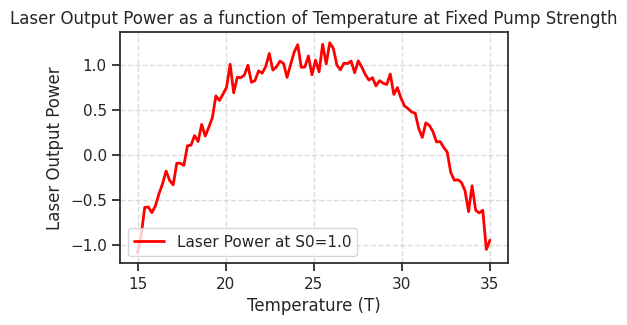

In [5]:
# Set up a fixed pump strength value
fixed_S0 = 1.0  # Fixed pump strength for this plot

# Set up a range of temperature values
T_values = np.linspace(15, 35, 100)  # Temperature range

# Simulate power for each temperature value
power_values_temp = np.array([laser_power(fixed_S0, T) for T in T_values])

# Plot the results
plt.figure(figsize=(5, 3))
plt.plot(T_values, power_values_temp, 'r-', lw=2, label='Laser Power at S0=1.0')
plt.xlabel('Temperature (T)')
plt.ylabel('Laser Output Power')
plt.title('Laser Output Power as a function of Temperature at Fixed Pump Strength')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower left')
plt.show()

#### Step 1.2: Define the Objective Function

For each combination of $S_0$ and $T$, we'll run the laser and measure the output power over time to get a sample of power values. The objective is to minimize the standard deviation of the output power:
$$
\text{obj}(S_0,T) = \text{std}(P(S_0,T))
$$

This will represent the stability of the laser.

In [6]:
def objective_function(S0, T, noise_level=0.1):
    """
    Laser power objective function.
    
    Args:
        S0: Pump strength.
        T: Temperature.
        noise_level: Level of Gaussian noise added to simulate fluctuations.

    Returns:
        Laser power for given S0 and T.
    """
    # Note: Ensure S0 is a 1D array for processing
    S0 = S0.reshape(-1)
    # Calculate the laser power using the laser power function
    power = laser_power(S0, T, noise_level=noise_level)
    return power

In [7]:
from bo_utils import *
from plotting_utils import *

#### Step 1.3: Make the Bayesian Optimization Loop

We can then use BO to minimize the standard deviation by adjusting $D_0$ and $T$. The acquisition function will guide the search for the best parameters that reduce noise.

Initial Y_init shape: (2,)
Iteration 1: S0_next = 23.039765945051982, Power = 3.2603836334877947
Iteration 2: S0_next = 35.573157128479465, Power = 4.584359135108543
Iteration 3: S0_next = 39.10742634470327, Power = 4.928280652375835
Iteration 4: S0_next = 44.5298577119712, Power = 5.4006732947030684
Iteration 5: S0_next = 49.53072661663023, Power = 5.970170960659187


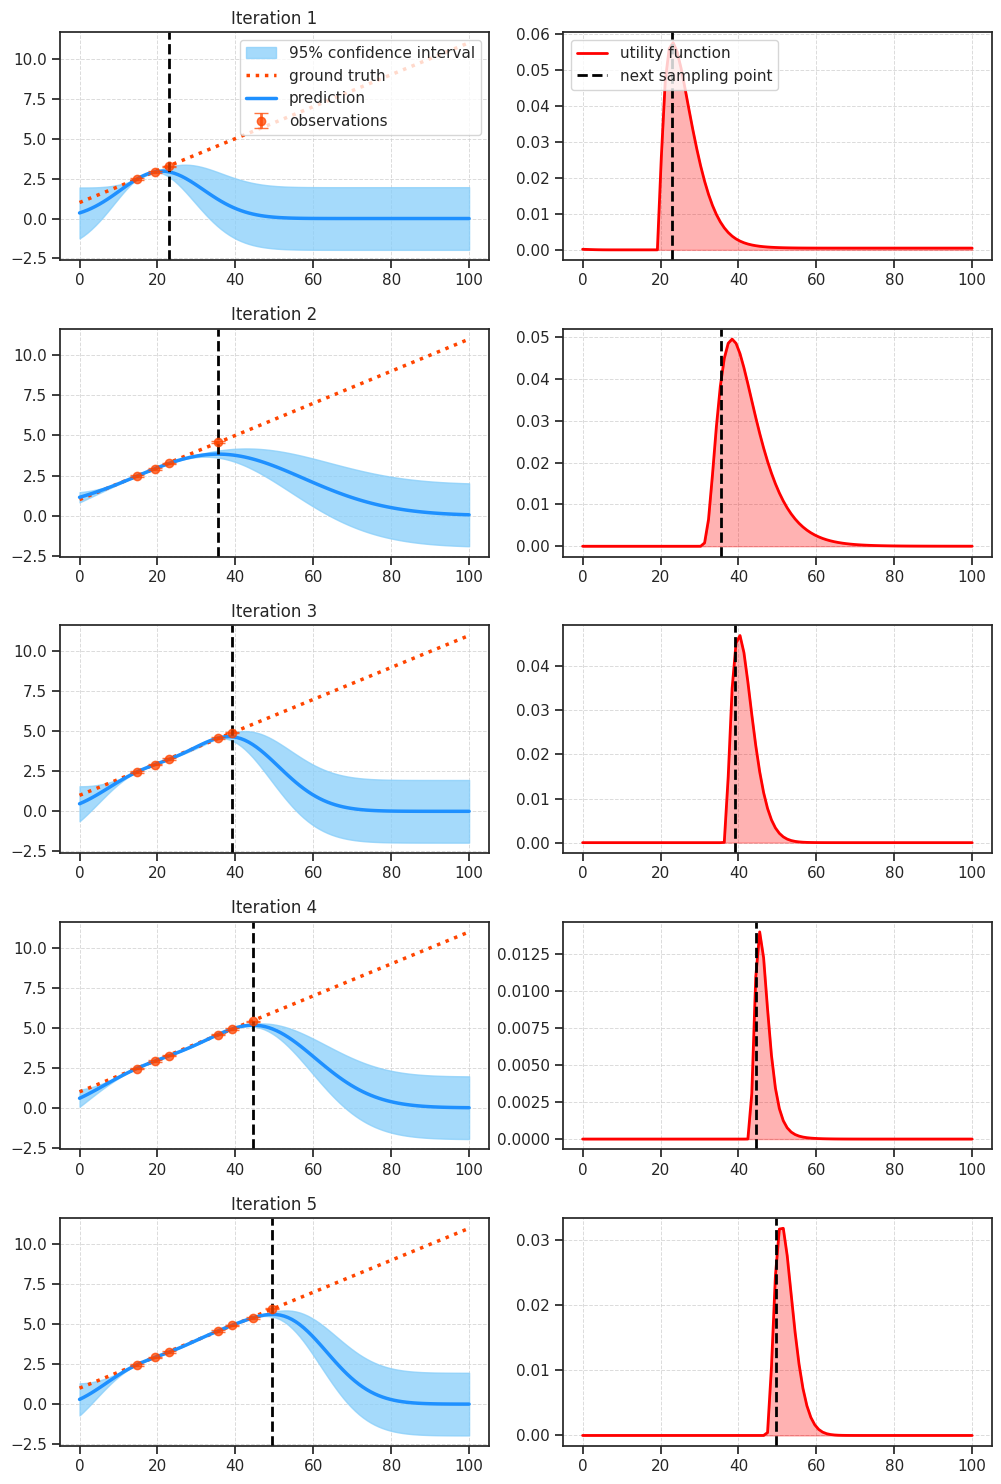

In [8]:
# Parameters for Bayesian optimization
n_iter = 5
n_init = 2 
n_points = 100
bounds = np.array([[0, n_points]])  # Define bounds for pump strength (e.g., 0 to 100)
noise_level = 0.05

# Initialize training data
S0_init = np.random.uniform(bounds[0, 0], bounds[0, 1], size=(n_init, 1))  # Random initial pump strengths
T_init = 25  # Set a fixed temperature for initial exploration
Y_init = objective_function(S0_init, T_init, noise_level=noise_level)  # Get initial laser power values
print("Initial Y_init shape:", Y_init.shape)  # Check shape

gp = GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=10)

# Prepare for plotting
X = np.linspace(bounds[0, 0], bounds[0, 1], 100).reshape(-1, 1)

# Calculate Y for reference (optional)
Y = objective_function(X, T_init, noise_level=0.0)  # Calculate true values at X without noise

fig, axes = plt.subplots(n_iter, 2, figsize=(10, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    gp.fit(S0_init, Y_init)
    
    # Suggest the next sampling point using the acquisition function
    S0_next = suggest_next_sample(expected_improvement, S0_init, Y_init, gp, bounds)
    
    # Obtain the next sample from the objective function
    Y_next = objective_function(S0_next, T_init, noise_level=noise_level)
    print(f"Iteration {i + 1}: S0_next = {S0_next.flatten()[0]}, Power = {Y_next.flatten()[0]}")
    
    # Reshape Y_init and Y_next if necessary
    if Y_init.ndim == 1:
        Y_init = Y_init.reshape(-1, 1)  # Ensure Y_init is a column vector
    Y_next = Y_next.reshape(-1, 1)  # Ensure Y_next is a column vector

    # Update the training data
    S0_init = np.vstack((S0_init, S0_next))
    Y_init = np.vstack((Y_init, Y_next))

    # Plot the GP approximation, noisy samples, and the next sampling point
    plot_prediction(axes[i, 0], gp, X, Y, S0_init, Y_init, S0_next, noise_level=noise_level, show_legend=(i == 0))
    axes[i, 0].set_title(f'Iteration {i + 1}')

    # Plot the acquisition (utility) function and the proposed next sample
    ei_values = expected_improvement(X, S0_init, Y_init, gp)
    plot_utility(axes[i, 1], X, ei_values, S0_next, show_legend=(i == 0))

# Show the plots
plt.tight_layout()
plt.show()


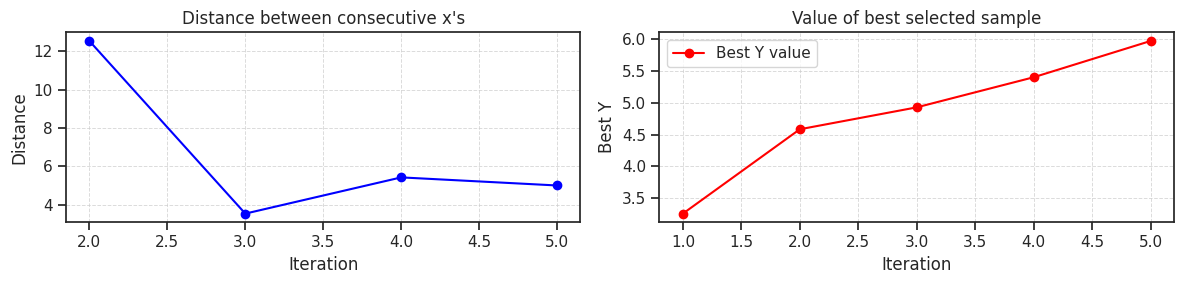

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))  # Create subplots
plot_convergence(ax, S0_init.ravel(), Y_init.ravel(), n_init=n_init, show_legend=True)
plt.show()  # Display the plots

#### Execise 2

Extend the laser optimization problem to tune both  pump strength $S_0$ and temperature $T$ simultaneously.

In [10]:
def objective_function(params, noise_level=0.05):
    S0, T = params[:, 0], params[:, 1]
    return laser_power(S0, T, noise_level=noise_level)

Check the $\texttt{suggest_next_sample}$ function: Modify it to ensure it returns a 2D array with two columns.

In [11]:
def suggest_next_sample(utility, X_train, Y_train, gp, bounds, n_restarts=25):
    """
    Suggests the next point to sample by optimizing the utility function.

    Args:
        utility: The utility function to be maximized.
        X_train: Training data input points (n x d).
        Y_train: Observed values corresponding to training points (n x 1).
        gp: A trained GaussianProcessRegressor model.
        bounds: Boundaries for the search space (d x 2).
        n_restarts: Number of random starting points for optimization.

    Returns:
        A proposed next sampling location with shape (1, d).
    """
    dim = X_train.shape[1]
    min_val = np.inf  # Initialize with a large value
    min_x = None  # Placeholder for the optimal point
    
    def min_obj(X):
        # Objective to minimize: negative of the acquisition function
        return -utility(X.reshape(-1, dim), X_train, Y_train, gp).flatten()
    
    # Search for the optimal point by trying multiple random n_restart points
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(1, -1)  # Return shape (1, d) for consistency

Here, we add a function for plotting the heatmap of the GP predictions or acquisition function. It highlights the suggested sample points and previously sampled points on the plot.

In [16]:
def plot_heatmap(ax, param1_grid, param2_grid, Y_pred, params_init, Y_init, param1_next, param2_next):
    heatmap = ax.imshow(Y_pred, extent=(param1_grid.min(), param1_grid.max(), param2_grid.min(), param2_grid.max()),
                        origin='lower', aspect='auto', cmap='viridis')
    ax.scatter(params_init[:, 0], params_init[:, 1], c='red', label='Initial Samples')
    ax.scatter(param1_next, param2_next, c='blue', marker='x', s=100, label='Next Sample')
    ax.set_xlabel('Pump Strength (S0)')
    ax.set_ylabel('Temperature (T)')
    # ax.set_title('Gaussian Process Prediction')
    ax.legend()
    plt.colorbar(heatmap, ax=ax, label='Predicted Power')
    

def plot_utility_2D(ax, S0_grid, T_grid, utility_values, X_next, show_legend=False, title=None):
    """
    Plot the utility (acquisition) function and the next proposed sampling point.

    Args:
        ax: Matplotlib axes to plot on.
        S0_grid: Values for the S0-axis (pump strength).
        T_grid: Values for the T-axis (temperature).
        utility_values: Utility function values corresponding to the grid.
        X_next: Next proposed sampling point (can be a scalar or array).
        show_legend: Boolean to show the legend.
        title: Optional title for the plot.
    """
    ax.clear()
    c = ax.contourf(S0_grid, T_grid, utility_values, levels=20, cmap='Reds', alpha=0.6)
    ax.set_xlabel('Pump Strength (S0)')
    ax.set_ylabel('Temperature (T)')
    ax.set_title('Utility Function')
    
    # Handle next sampling point for both 1D and 2D
    if X_next.ndim == 1:  # If X_next is a single point (1D)
        ax.axvline(x=X_next[0], ls='--', c='k', lw=2, label='Next Sampling Point')
    elif X_next.ndim == 2:  # If X_next contains multiple dimensions (2D)
        ax.scatter(X_next[:, 0], X_next[:, 1], c='blue', marker='x', s=100, label='Next Sampling Points')

    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    
    if show_legend:
        ax.legend(loc="upper left")

    if title is not None:
        ax.set_title(title)

Iteration 1: S0_next = 87.27157881548673, T_next = 15.0780938246885, Power = 7.719094473246903
Iteration 2: S0_next = 89.30961560270306, T_next = 20.413899969030926, Power = 9.546381840802303
Iteration 3: S0_next = 89.6470098147162, T_next = 21.231779142020944, Power = 9.792056369743843
Iteration 4: S0_next = 92.17949960099656, T_next = 29.05174075030555, Power = 9.861115698325074
Iteration 5: S0_next = 90.79400230918158, T_next = 25.506750235947255, Power = 9.968730272506086
Iteration 6: S0_next = 26.51384037080429, T_next = 33.51302413866519, Power = 2.2766553832028755
Iteration 7: S0_next = 97.45611837367615, T_next = 34.14200641760485, Power = 9.10526813167875
Iteration 8: S0_next = 94.6477386273371, T_next = 31.067657184770617, Power = 9.702174539758854


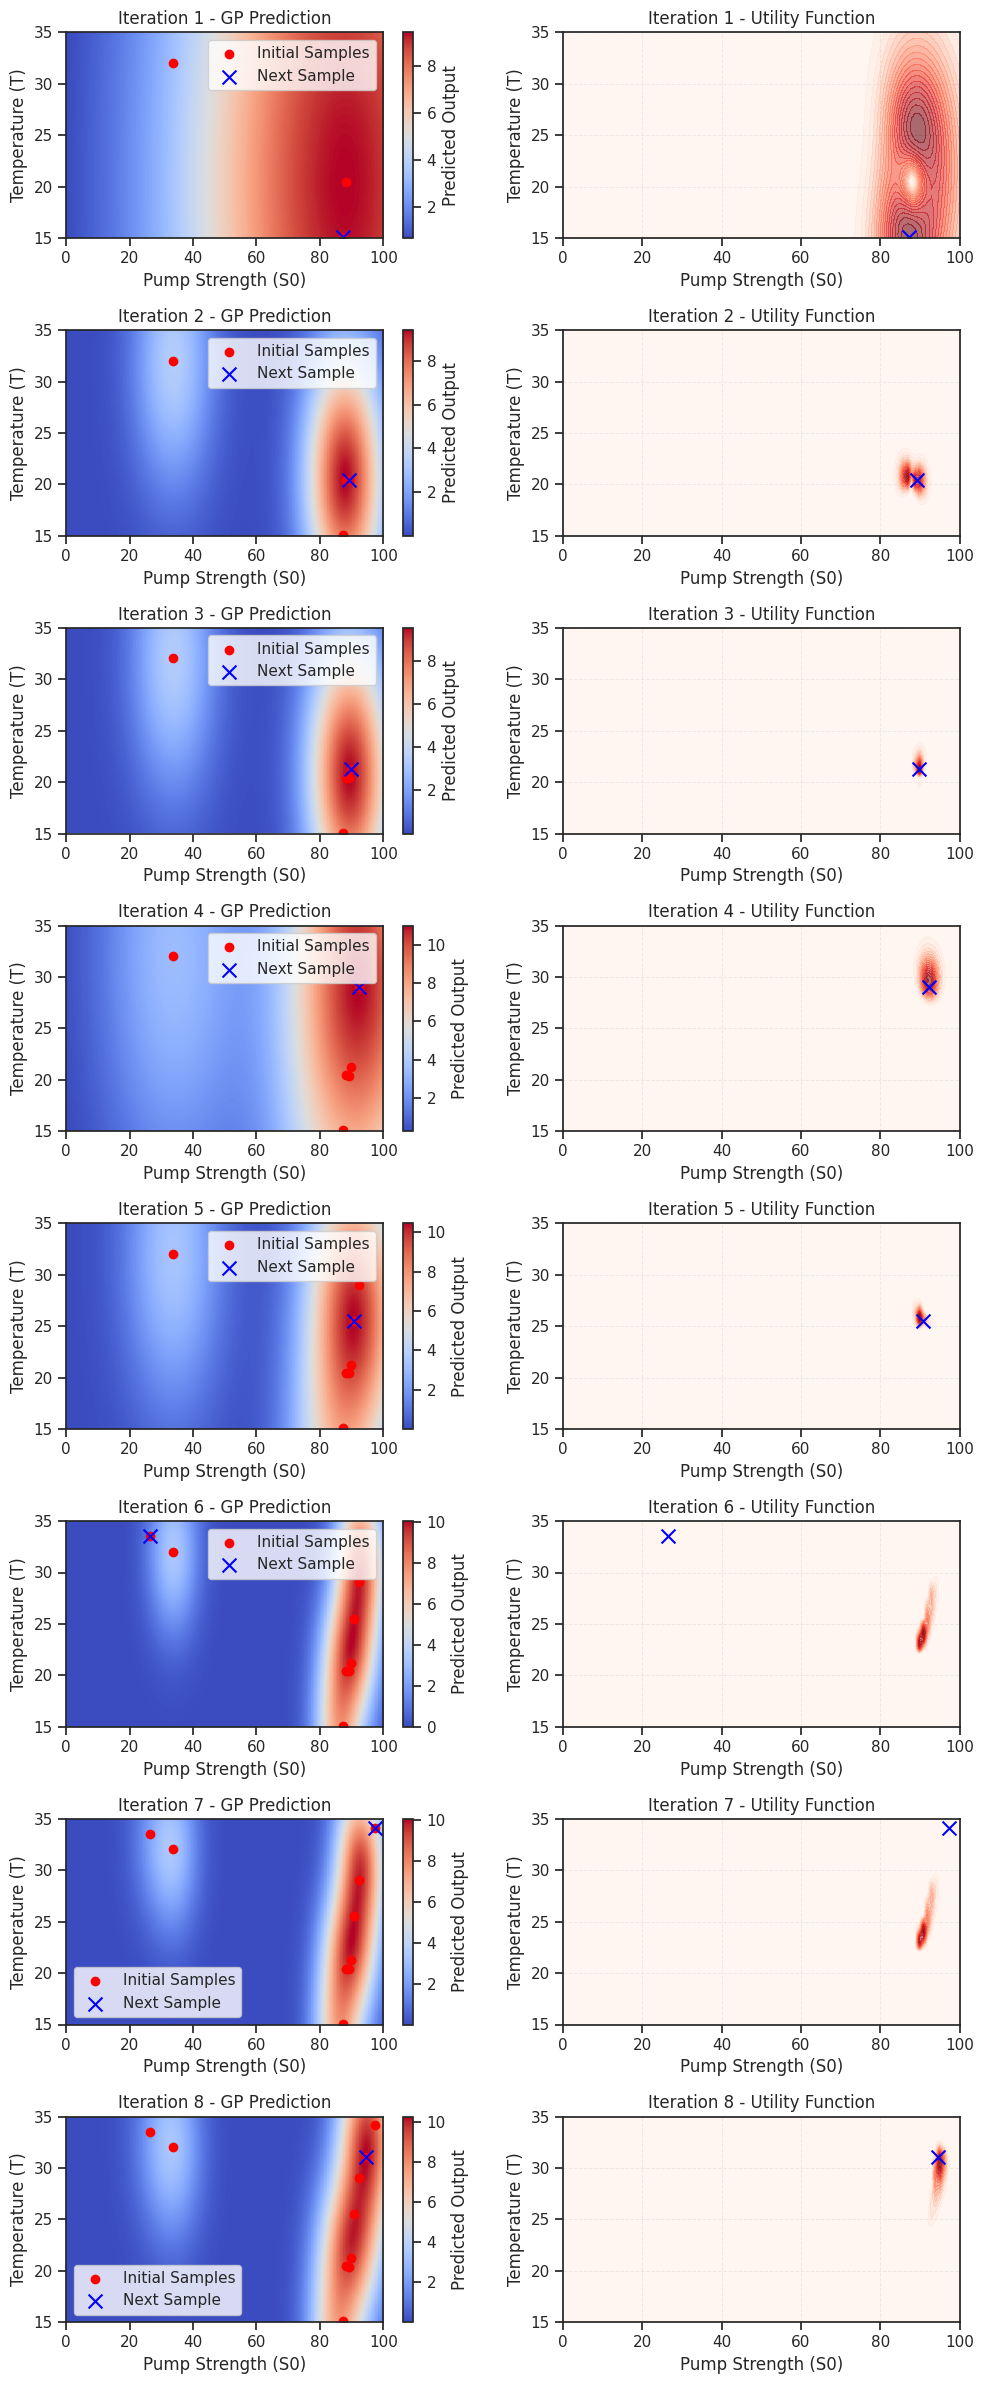

In [14]:
from plotting_utils import plot_heatmap, plot_utility_2D

# Parameters for Bayesian optimization
n_iter = 8
n_init = 2 
n_points = 100
# Set the bounds for the parameters (S0, T)
bounds = np.array([[0, 100],  # Pump strength range
                   [15, 35]])  # Temperature range
noise_level = 0.05

# Initialize training data
S0_init = np.random.uniform(bounds[0, 0], bounds[0, 1], size=(n_init, 1))  # Initial pump strengths
T_init = np.random.uniform(bounds[1, 0], bounds[1, 1], size=(n_init, 1))  # Initial temperatures
params_init = np.hstack((S0_init, T_init))  # Combine pump strength and temperature
# print("params_init:", params_init)
Y_init = objective_function(params_init, noise_level=noise_level)  # Initial laser power values
# print("Initial Y_init shape:", Y_init.shape)

gp = GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=10)

# Prepare for plotting
S0_range = np.linspace(bounds[0, 0], bounds[0, 1], n_points)
T_range = np.linspace(bounds[1, 0], bounds[1, 1], n_points)
S0_grid, T_grid = np.meshgrid(S0_range, T_range)
X = np.vstack([S0_grid.ravel(), T_grid.ravel()]).T
# print("X:", X)

# Calculate Y for reference (optional)
Y_true = objective_function(X, noise_level=0.0).reshape(n_points, n_points)  # True values without noise

fig, axes = plt.subplots(n_iter, 2, figsize=(10, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    gp.fit(params_init, Y_init)
    
    # Suggest the next sampling point using the acquisition function
    params_next = suggest_next_sample(expected_improvement, params_init, Y_init, gp, bounds)
    # print("params_next:", params_next)

    # Reshape if necessary to ensure it's 2D with two columns (for S0 and T)
    if params_next.ndim == 1:
        params_next = params_next.reshape(1, -1)

    # Extract S0 and T from suggested params
    S0_next, T_next = params_next[0, 0], params_next[0, 1]

    # Obtain the next sample from the objective function
    Y_next = objective_function(params_next, noise_level=noise_level)
    print(f"Iteration {i + 1}: S0_next = {S0_next}, T_next = {T_next}, Power = {Y_next.flatten()[0]}")
    
    Y_next = Y_next.reshape(-1, 1)  # Ensure Y_next is 2D with shape (1, 1)

    # print(f"Y_init shape: {Y_init.shape}")
    # print(f"Y_next shape: {Y_next.shape}")

    # Reshape Y_init if necessary
    if Y_init.ndim == 1:
        Y_init = Y_init.reshape(-1, 1)  # Ensure Y_init is a column vector

    # Update the training data
    params_init = np.vstack((params_init, params_next))
    Y_init = np.vstack((Y_init, Y_next))  # Now both should have compatible shapes
    
    # Plot the GP approximation and noisy samples
    Y_pred, sigma = gp.predict(X, return_std=True)
    Y_pred = Y_pred.reshape(n_points, n_points)
    sigma = sigma.reshape(n_points, n_points)
    
    # plot_heatmap(axes[i, 0], S0_grid, T_grid, Y_pred, params_init, Y_init, S0_next, T_next)
    # axes[i, 0].set_title(f'Iteration {i + 1} - GP Prediction')
    plot_heatmap(axes[i, 0], S0_grid, T_grid, Y_pred, params_init, Y_init, S0_next, T_next, 
                 param1_label='Pump Strength (S0)', param2_label='Temperature (T)', title=f'Iteration {i + 1} - GP Prediction')
    
    # Plot the acquisition (utility) function
    ei_values = expected_improvement(X, params_init, Y_init, gp).reshape(n_points, n_points)
    next_params = np.array([[S0_next, T_next]])  # Shape (1, 2) for 2D points
    
    # plot_utility_2D(axes[i, 1], S0_grid, T_grid, ei_values, next_params, show_legend=True, title=f'Iteration {i + 1} - Utility Function')
    plot_utility_2D(axes[i,1], S0_grid, T_grid, ei_values, next_params, 
                    param1_label='Pump Strength (S0)', param2_label='Temperature (T)', title=f'Iteration {i + 1} - Utility Function')

    
# Show the plots
plt.tight_layout()
plt.show()

### Exploration

In the next 45 minutes, work in a group of 3's. Extend the exercises above to incorporate the following:

- Add an additional parameter, wavelength $\lambda$, to perform 3-parameter BO.
- Generalize the functions to include this third parameter.
- Observe what happens when you change the following:
    - Type of Kernel
    - Type of Utility Function
- Plot your results:
    - You can do this by plotting two parameters at a time for the heatmap and utility function.
- Perform random grid search instead and compare the results with BO.